In [34]:
import pandas as pd
import numpy as np
import pathlib
import awkward as ak
import librosa
from tqdm.notebook import tqdm


import matplotlib.pyplot as plt

<h2>Local import</h2>

In [35]:
dataset_folder = pathlib.Path("RavdessAudioOnly/")

In [36]:
dataset_folder

PosixPath('RavdessAudioOnly')

In [37]:
file_list = list(dataset_folder.iterdir())
for i, path in enumerate(file_list):
    if path.suffix != ".wav":
        file_list.pop(i)
file_list = sorted(file_list)
file_list

[PosixPath('RavdessAudioOnly/03-01-01-01-01-01-01.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-02.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-03.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-04.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-05.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-06.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-07.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-08.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-09.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-10.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-11.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-12.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-13.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-14.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-15.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-16.wav'),
 PosixPath('RavdessAudioOnly/03-01-01-01-01-01-17.wav'),
 PosixPath('RavdessAudioOnly/03

In [ ]:
array = list()
for path in file_list:
    librosa_audio_segment, sr = librosa.load(path, sr=None)
    array.append([librosa_audio_segment])

In [ ]:
b = ak.ArrayBuilder()
for path in file_list:
    librosa_audio_segment, sr = librosa.load(path, sr=None)
    b.begin_list()
    b.begin_list()
    for value in librosa_audio_segment:
        b.real(value)
    b.end_list() 
    b.end_list() 
array = b.snapshot()

In [ ]:
CATEGORICAL_FEATURES_NAMES = {
    "modality": {"01": "full-AV", "02": "video-only", "03": "audio-only"}, 
    "vocal_channel": {"01": "speech", "02": "song"},
    "emotion": {"01" : "neutral", "02" : "calm", "03" : "happy", "04" : "sad", "05" : "angry", "06" : "fearful", "07" : "disgust", "08" : "surprised"},
    "emotional_intensity": {"01" : "normal", "02" : "strong"},
    "statement": {"01" : "Kids are talking by the door", "02" : "Dogs are sitting by the door"},
    "repetition": {"01" : "1st", "02" : "2nd"},
    "actor": {str(i).zfill(2): str(i).zfill(2) for i in range(1, 25)}
}

In [ ]:
df = list()
file_names = list()
for path in file_list:
    stem = path.stem.split("-")
    file_names.append(path.name)
    df.append(stem)
df = pd.DataFrame(df)
df.columns = list(CATEGORICAL_FEATURES_NAMES.keys())

for column in df.columns:
    df = df.replace(CATEGORICAL_FEATURES_NAMES)

df["sex"] = ["F" if i % 2 == 0 else "M" for i in df["actor"].astype(int)]
df["filename"] = file_names

In [ ]:
df.head()

In [ ]:
df_sorted_actor = df.sort_values(by=["actor", "filename"])
idxs_sorted = list(df_sorted_actor.index)

In [ ]:
idx_train = list(df_sorted_actor[df_sorted_actor.actor.astype(int) < 19].index)
idx_test = list(df_sorted_actor[df_sorted_actor.actor.astype(int) >= 19].index)

In [ ]:
X_train = array[idx_train]
X_test = array[idx_test]
Y_train = df_sorted_actor[df_sorted_actor.actor.astype(int) < 19]
Y_test = df_sorted_actor[df_sorted_actor.actor.astype(int) >= 19]

In [ ]:
def pad_X(X, m_max, nan_value=0):
    return ak.fill_none(ak.pad_none(X, m_max, axis=2, clip=True), value=nan_value)
#since they are audio files it maes sense that the nan value is zero, but we could put NaN and then deal with it later

In [ ]:
# find the max length of X_train
maximum = 0
for ts in X_train:
    length = len(np.asarray(np.ravel(ts)))
    if length > maximum:
        maximum = length
maximum
#in order to know to which length to put the audios, we look at the maximum length in the train, because as a principle we cannot use informations of the test to make decisions 
#on the whole dataset. So if there is a longer audio in the test it will be cut, but it's good like this

In [ ]:
X_train = np.squeeze(np.array(pad_X(X_train, maximum, 0)))
X_test = np.squeeze(np.array(pad_X(X_test, maximum, 0)))

In [ ]:
np.save("RavdessAudioOnlyNumpy__X_train.npy", X_train)
np.save("RavdessAudioOnlyNumpy__X_test.npy", X_test)

<h2>TS - prep</h2>

In [ ]:
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt 

In [ ]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import matplotlib.pyplot as plt 

In [ ]:
!pip install numpy=={"1.20.3"} numba

In [ ]:
import numpy as np

In [ ]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from tslearn.piecewise import SymbolicAggregateApproximation
from tslearn.piecewise import OneD_SymbolicAggregateApproximation

In [45]:
X_train=np.load('RavdessAudioOnlyNumpy__X_train.npy')
X_test=np.load('RavdessAudioOnlyNumpy__X_test.npy')

In [ ]:
X_train.shape 

(1828, 92672)

In [ ]:
X_test.shape 

(624, 92672)

<h4>TS Approximation</h4>

We do approximation to represent a TS into a new smaller and simpler space and use this novel representation for computing, so that the task can be more effectively done on a reduced TS. It's a special form of dimensionality reduction specifically designed for TS. <br>
We first do a moving avg smoothing, per ridurre il rumore e fare un primo smoothing della TS. <br>
Scaliamo poi i dati per fare in modo che abbiano media intorno a 0 e varianza 1 <br>
Poi facciamo le diverse approssimazioni per poter avere delle TS ridotte. 

In [ ]:
def moving_average_smoothing(series, window_size):
    """
    Perform moving average smoothing on a single time series.
    
    series: Input time series as a 1-dimensional numpy array.
    window_size: Size of the moving window as an integer.
    
    Returns the smoothed time series.
    """
    window = np.ones(window_size) / window_size
    smoothed_series = np.convolve(series, window, mode='same')
    return smoothed_series

In [ ]:
X_train_smoothed = np.empty_like(X_train)

In [ ]:
X_train_smoothed.shape

(1828, 92672)

In [ ]:
for i,time_series in enumerate (X_train):
    X_train_smoothed[i]= moving_average_smoothing(X_train[i], 10)

In [ ]:
ts1=X_train[42]
ts1s=X_train_smoothed[42]

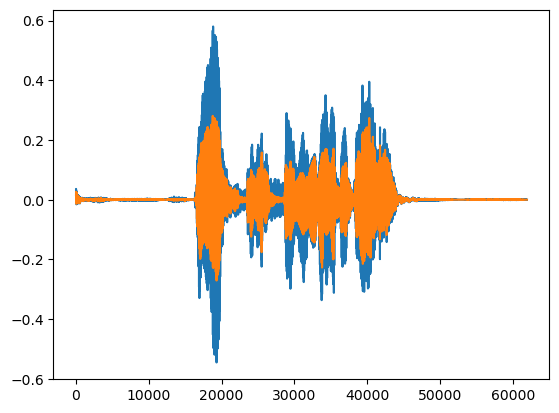

In [ ]:
#plot con window=10
plt.plot(ts1)
plt.plot(ts1s)
plt.show()

In [39]:
X_test_smoothed = np.empty_like(X_test)

In [40]:
for i,time_series in enumerate (X_test):
    X_test_smoothed[i]= moving_average_smoothing(X_test[i], 10)

In [41]:
#faccio lo scaling direttamente su quelle smoothed
X_test_smoothed=TimeSeriesScalerMeanVariance().fit_transform(X_test_smoothed)
X_train_smoothed=TimeSeriesScalerMeanVariance().fit_transform(X_train_smoothed)

In [53]:
np.save("RavdessAudioOnlyNumpy__X_train_smoothed_scaled.npy", X_train_smoothed)
np.save("RavdessAudioOnlyNumpy__X_test_smoothed_scaled.npy", X_test_smoothed)

In [56]:
print(X_train_smoothed.shape)
print(X_test_smoothed.shape)

(1828, 92672, 1)
(624, 85500, 1)


<h4>Approximation</h4>
Facciamo tre versioni: SAX, PAA e DFT

In [66]:
## SAX with 50 symbols and 500 segments - erano quelli che plottando la TS davano risultato migliore

n_sax_symbols = 50
sax = SymbolicAggregateApproximation(n_segments=500, 
                                     alphabet_size_avg=n_sax_symbols)
X_train_sax = sax.fit_transform(X_train_smoothed)
#sax_dataset_inv = sax.inverse_transform(X_train_sax)

In [67]:
X_train_sax.shape

(1828, 500, 1)

In [68]:
np.unique(X_train_sax[42], return_counts=True)

(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31]),
 array([  1,   2,   5,  17,  37, 202, 183,  21,  23,   5,   3,   1]))

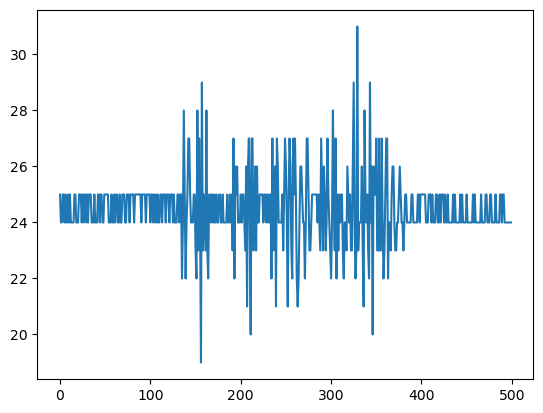

In [69]:
plt.plot(X_train_sax[42])

In [70]:
## DFT

from pyts.approximation import DiscreteFourierTransform

In [74]:
X_train=np.load('RavdessAudioOnlyNumpy__X_train.npy')

In [75]:
X_train=np.nan_to_num(X_train, nan=0)

In [76]:
dft = DiscreteFourierTransform(n_coefs=64)
X_train_DFT = dft.fit_transform(X_train)

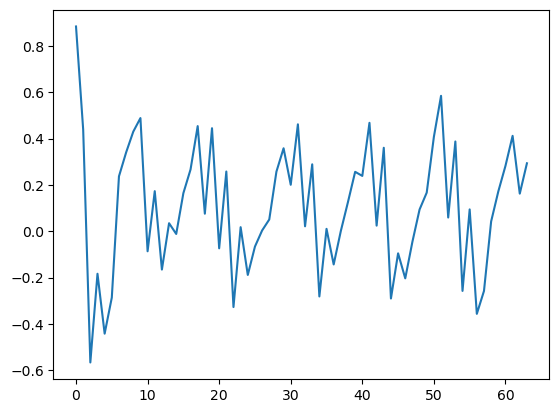

In [77]:
plt.plot(X_train_DFT[42])

In [78]:
X_train_DFT.shape

(1828, 64)

In [83]:
#PAA con 500 segmenti (per coerenza e confronto con sax)

paa = PiecewiseAggregateApproximation(n_segments=500)
X_train_paa = paa.fit_transform(X_train_smoothed)

In [84]:
X_train_paa.shape

(1828, 500, 1)

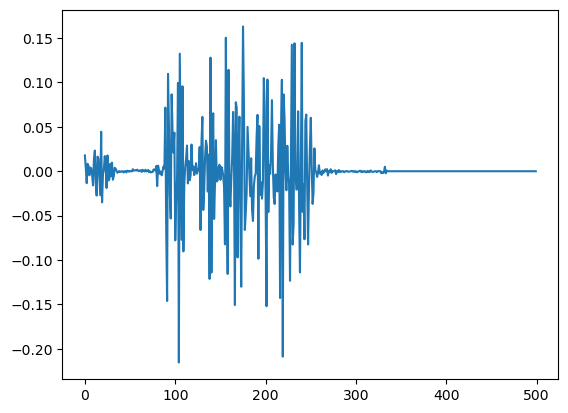

In [86]:
plt.plot(X_train_paa[42])

In [87]:
np.save("X_train_sax.npy", X_train_sax)
np.save("X_train_dft.npy", X_train_DFT)
np.save("X_train_paa.npy", X_train_paa)
